In [1]:
import pandas as pd
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os
from skimage.transform import rescale
from skimage.color import rgb2gray, gray2rgb
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset, random_split
from torchvision import transforms, utils
import random
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import time
import cv2
from PIL import Image

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.ion()

In [3]:
dataframe=pd.read_csv('celeb.csv')

In [4]:
class PlacesDataset(Dataset):
    def __init__(self,df,img_dir,transform=None):
        self.df=df
        self.img_dir=img_dir
        self.transform=transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        img_path=os.path.join(self.img_dir,'{}'.format(self.df.loc[idx]['image']))
        if(img_path is not None):
            mpv=0.4381295423217147
            image=Image.open(img_path)
            sample={'orig_image':image}
            if self.transform:
                sample['orig_image']=self.transform(sample['orig_image'])
                mask=np.zeros((160,160,3))
                mask[60:100,60:100,:]=1
                mask=transforms.functional.to_tensor(mask)
                mask=mask.type(torch.FloatTensor)
                new_image=sample['orig_image']-sample['orig_image']*mask+mpv*mask
                sample['new_image']=new_image
                sample['mask']=mask
            
            return sample

In [5]:
train=dataframe[:200000]
validation=dataframe[200000:200059]
test=dataframe[200059:202599]
validation=validation.reset_index(drop=True)
test=test.reset_index(drop=True)
train_data=PlacesDataset(train,img_dir='images/CelebA/',transform=transforms.Compose([transforms.Resize(160),transforms.RandomCrop((160,160)),transforms.ToTensor()]))
validation_data=PlacesDataset(validation,img_dir='images/CelebA/',transform=transforms.Compose([transforms.Resize(160),transforms.RandomCrop((160,160)),transforms.ToTensor()]))
test_data=PlacesDataset(test,img_dir='images/CelebA/',transform=transforms.Compose([transforms.Resize(160),transforms.RandomCrop((160,160)),transforms.ToTensor()]))

In [6]:
for i in range(1034,1038):
    sample=train_data[i]
    print (i,sample['orig_image'].size(),sample['new_image'].size(),sample['mask'].size())

1034 torch.Size([3, 160, 160]) torch.Size([3, 160, 160]) torch.Size([3, 160, 160])
1035 torch.Size([3, 160, 160]) torch.Size([3, 160, 160]) torch.Size([3, 160, 160])
1036 torch.Size([3, 160, 160]) torch.Size([3, 160, 160]) torch.Size([3, 160, 160])
1037 torch.Size([3, 160, 160]) torch.Size([3, 160, 160]) torch.Size([3, 160, 160])


In [7]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [8]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,batch_size=16)
validation_loader = torch.utils.data.DataLoader(validation_data,batch_size=1)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=1)

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.act1 = nn.ReLU()
        # input_shape: (None, 64, img_h, img_w)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.act2 = nn.ReLU()
        # input_shape: (None, 128, img_h//2, img_w//2)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.act3 = nn.ReLU()
        # input_shape: (None, 128, img_h//2, img_w//2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.act4 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.act5 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.act6 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=2, padding=2)
        self.bn7 = nn.BatchNorm2d(256)
        self.act7 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=4, padding=4)
        self.bn8 = nn.BatchNorm2d(256)
        self.act8 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv9 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=8, padding=8)
        self.bn9 = nn.BatchNorm2d(256)
        self.act9 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv10 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=16, padding=16)
        self.bn10 = nn.BatchNorm2d(256)
        self.act10 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv11 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn11 = nn.BatchNorm2d(256)
        self.act11 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv12 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn12 = nn.BatchNorm2d(256)
        self.act12 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.deconv13 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.bn13 = nn.BatchNorm2d(128)
        self.act13 = nn.ReLU()
        # input_shape: (None, 128, img_h//2, img_w//2)
        self.conv14 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn14 = nn.BatchNorm2d(128)
        self.act14 = nn.ReLU()
        # input_shape: (None, 128, img_h//2, img_w//2)
        self.deconv15 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.bn15 = nn.BatchNorm2d(64)
        self.act15 = nn.ReLU()
        # input_shape: (None, 64, img_h, img_w)
        self.conv16 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.bn16 = nn.BatchNorm2d(32)
        self.act16 = nn.ReLU()
        # input_shape: (None, 32, img_h, img_w)
        self.conv17 = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)
        self.act17 = nn.Sigmoid()
        
    def forward(self,x):
        x = self.bn1(self.act1(self.conv1(x)))
        x = self.bn2(self.act2(self.conv2(x)))
        x = self.bn3(self.act3(self.conv3(x)))
        x = self.bn4(self.act4(self.conv4(x)))
        x = self.bn5(self.act5(self.conv5(x)))
        x = self.bn6(self.act6(self.conv6(x)))
        x = self.bn7(self.act7(self.conv7(x)))
        x = self.bn8(self.act8(self.conv8(x)))
        x = self.bn9(self.act9(self.conv9(x)))
        x = self.bn10(self.act10(self.conv10(x)))
        x = self.bn11(self.act11(self.conv11(x)))
        x = self.bn12(self.act12(self.conv12(x)))
        x = self.bn13(self.act13(self.deconv13(x)))
        x = self.bn14(self.act14(self.conv14(x)))
        x = self.bn15(self.act15(self.deconv15(x)))
        x = self.bn16(self.act16(self.conv16(x)))
        x = self.act17(self.conv17(x))
        
        return x

In [10]:
def train_generator(model,train_loader,g_optimizer,g_criterion,epoch,num_epochs,epochs,rl_g):
    running_loss=0
    generator.train()
    for i,(sample) in enumerate(train_loader):
        i_o=Variable(sample['orig_image']).to(device)
        i_n=Variable(sample['new_image']).to(device)
        mask=Variable(sample['mask']).to(device)
        
       
        g_optimizer.zero_grad()
        i_g=generator(i_n)
        loss=g_criterion(torch.mul(i_g,mask),torch.mul(i_o,mask))
        loss.backward()
        g_optimizer.step()
        running_loss+=loss.item()
        rl_g.append(loss.item())
        if((i+1)%1250==0):
            print('Epoch: [{}/{}] | Step: [{}/{}] | Loss: {}'.format(epoch+1-epochs, num_epochs, int((i+1)/1250),10 , round(running_loss/1250,4)))
            running_loss=0

In [11]:
generator = Generator()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
generator=generator.to(device)
g_criterion = nn.MSELoss()
g_optimizer = torch.optim.Adadelta(generator.parameters())

cuda:0


In [12]:
num_epochs_gen=5
checkpoint = torch.load('Generator/model_2.pth')
generator.load_state_dict(checkpoint['model_state_dict'])
g_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epochs_gen = checkpoint['epoch']
rl_g = checkpoint['loss']

generator.eval()

Generator(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): ReLU()
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act4): ReLU()
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act5): ReLU()
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [ ]:
#epochs_gen=0
#num_epochs_gen=8
#rl_g=[]
for epoch_gen in range(epochs_gen,num_epochs_gen+epochs_gen):
    train_generator(generator,train_loader,g_optimizer,g_criterion,epoch_gen,num_epochs_gen,epochs_gen,rl_g)
    print ('%---Saving the model---%')
    torch.save({
            'epoch': int(epoch_gen)+1,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': g_optimizer.state_dict(),
            'loss': rl_g,
            },'Generator/model_{}.pth'.format(epoch_gen+1))

Epoch: [1/5] | Step: [1/10] | Loss: 0.0005
Epoch: [1/5] | Step: [2/10] | Loss: 0.0005
Epoch: [1/5] | Step: [3/10] | Loss: 0.0005
Epoch: [1/5] | Step: [4/10] | Loss: 0.0005
Epoch: [1/5] | Step: [5/10] | Loss: 0.0005
Epoch: [1/5] | Step: [6/10] | Loss: 0.0005
Epoch: [1/5] | Step: [7/10] | Loss: 0.0005
Epoch: [1/5] | Step: [8/10] | Loss: 0.0005
Epoch: [1/5] | Step: [9/10] | Loss: 0.0005
Epoch: [1/5] | Step: [10/10] | Loss: 0.0005
%---Saving the model---%
Epoch: [2/5] | Step: [1/10] | Loss: 0.0005
Epoch: [2/5] | Step: [2/10] | Loss: 0.0005
Epoch: [2/5] | Step: [3/10] | Loss: 0.0005
Epoch: [2/5] | Step: [4/10] | Loss: 0.0005
Epoch: [2/5] | Step: [5/10] | Loss: 0.0005
Epoch: [2/5] | Step: [6/10] | Loss: 0.0005
Epoch: [2/5] | Step: [7/10] | Loss: 0.0005
Epoch: [2/5] | Step: [8/10] | Loss: 0.0005
Epoch: [2/5] | Step: [9/10] | Loss: 0.0005
Epoch: [2/5] | Step: [10/10] | Loss: 0.0005
%---Saving the model---%
Epoch: [3/5] | Step: [1/10] | Loss: 0.0005
Epoch: [3/5] | Step: [2/10] | Loss: 0.0005
Ep

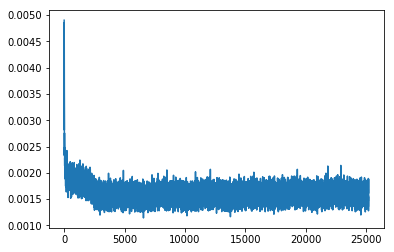

In [14]:
plt.plot(range(len(rl_g)),(rl_g))
plt.show()

In [ ]:
mask=np.zeros(160,160,3)